In [ ]:
##### FORTUNE POEM GENERATOR

In [1]:
##### IMPORTS FOR POEM GENERATOR
from itertools import chain
from collections import Counter
import nltk
nltk.download('punkt')
from scipy import stats
from random import randrange # for starter_word

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ceren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
##### CORPUS TOKENIZATION AND TRIGRAM CREATION
file_name = "resources/datasets/ngram_corpus.txt"
file_content = open(file_name, "r", encoding='utf-8-sig').read().lower()
tokens = file_content.split("\n")
tokens_sents = [nltk.word_tokenize(sentence) for sentence in tokens]
corpus = []
for sentence in tokens_sents:
  corpus += ["<s>"]+sentence+["</s>"]
ts_trigrams = [((corpus[i], corpus[i+1]), corpus[i+2]) for i in range(len(corpus)-2)]
trigram_cfd = nltk.ConditionalFreqDist(ts_trigrams)
trigram_pbs = nltk.ConditionalProbDist(trigram_cfd, nltk.MLEProbDist)

In [7]:
##### STARTER WORD GENERATOR
def generateStarterWord():
  starter_word_set = []
  for i in range(len(tokens_sents)-1):
    starter_word_set.append(tokens_sents[i][0])
  starter_word_set = list(set(starter_word_set)) # list -> set -> list; gets rid of duplicate entries
  starter_word_index = randrange(len(starter_word_set)) # random integer under a max number
  starter_word = starter_word_set[starter_word_index] # random word from the corpus to start the poem writing ngram

  return starter_word

In [ ]:
##### CLASSIFICATION MODEL

In [9]:
##### IMPORTS FOR CLASSIFICATION MODEL
import numpy as np
import pandas as pd
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

c:\Users\ceren\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
##### DATA PREPERATION
data=pd.read_excel("resources/datasets/training_corpus.xlsx")
data['labels'] = pd.factorize(data.categories)[0]
train, test = train_test_split(data, test_size=0.2, random_state=42)
train=train[["sentences","labels"]]
test=test[["sentences","labels"]]
train["sentences"]=train["sentences"].apply(lambda r: str(r))
train['labels']=train['labels'].astype(int)

In [13]:
##### RUN IF MODEL IS ALREADY SAVED, ADJUST THE CUDA USAGE TO FIT YOUR SETUP
model = ClassificationModel('bert','resources/model', use_cuda=False)

In [ ]:
##### PREPARING THE MODEL AND TRAINING, DO NOT RUN IF THE MODEL IS SAVED
#model = ClassificationModel('bert', 'dbmdz/bert-base-turkish-uncased', num_labels=2, use_cuda=True, weight=[0.9, 1],
#                            args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs': 5, "train_batch_size": 50 , "fp16":False, "output_dir": "bert_model"})
#model_stats = model.train_model(train)

In [14]:
##### MODEL EVALUATION
result, model_outputs, wrong_predictions = model.eval_model(test)
predictions = model_outputs.argmax(axis=1)
actuals = test.labels.values
predictions[:90]
actuals[:90]
accuracy_score(actuals, predictions)

c:\Users\ceren\AppData\Local\Programs\Python\Python312\Lib\site-packages\simpletransformers\classification\classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
1it [00:06,  6.99s/it]
Running Evaluation: 100%|██████████| 2/2 [00:16<00:00,  8.29s/it]


0.9306930693069307

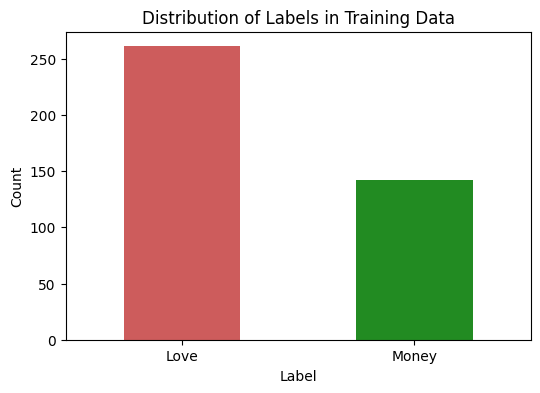

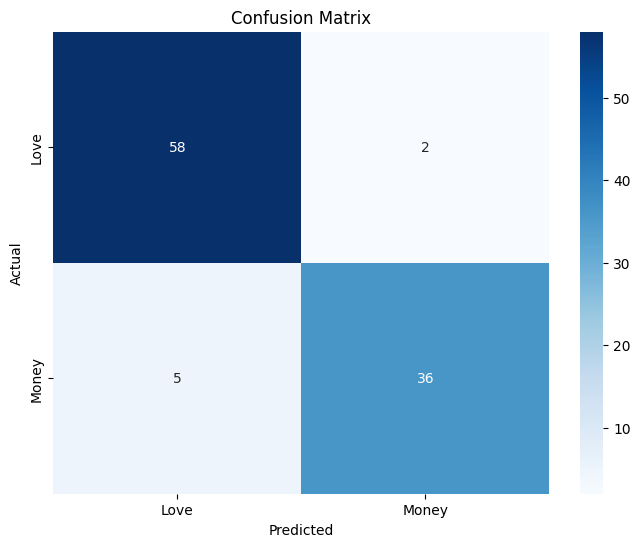

In [15]:
##### MODEL METRICS

#Distrubition of data
plt.figure(figsize=(6, 4))
colors = ['indianred' if label == 0 else 'forestgreen' for label in train['labels']]
train['labels'].value_counts().plot(kind='bar', color=colors)
plt.xticks(ticks=[0, 1], labels=['Love', 'Money'], rotation=0)
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Confusion Matrix
cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Love', 'Money'], yticklabels=['Love', 'Money'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

label_counts = data['labels'].value_counts()



In [16]:
##### PREDICTION FUNCTION
def predictSentence(sentence):
  res=model.predict([sentence])[0][0]
  if res == 0:
   return "love"
  else:
   return "money"

In [25]:
##### CODE FOR NGRAMS AND RESULT
def generatePoem(label):
  starter_word = generateStarterWord()
  current_phrase = ('<s>',starter_word)
  current = f"<s> {starter_word}"
  line_counter = 0
  poemFinished = False
  poem = []
  while not poemFinished:
    probable_words = list(trigram_pbs[current_phrase].samples())
    word_probabilities = [trigram_pbs[current_phrase].prob(word) for word in probable_words]
    result = stats.multinomial.rvs(1,word_probabilities)
    random_index = list(result).index(1)
    current_phrase = (current_phrase[1],(probable_words[random_index]))
    current += f" {probable_words[random_index]}"
    if current_phrase[1] == "</s>":
      if predictSentence(current[3:-4]) == label:
        poem.append(current)
        line_counter += 1
      current = ""
    if line_counter == 4: # restricts the line count per poem to 4
      poemFinished = True
      return poem

In [26]:
##### FUNCTION FOR PRINTING POSTPROCESSED POEM
def printPoem(poem):
    for line in poem:
        cropped_line = line[4:-4].strip()
        formatted_line = f"{cropped_line[0].upper()}{cropped_line[1:]}"
        print(formatted_line)
    

In [27]:
# It will continue generating texts until it finds 4 matching sentences with the entered theme.
poem = generatePoem("money")

1it [00:07,  7.26s/it]
100%|██████████| 1/1 [00:00<00:00,  5.29it/s]
1it [00:06,  6.49s/it]
100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
1it [00:06,  6.71s/it]
100%|██████████| 1/1 [00:00<00:00,  5.71it/s]
1it [00:06,  6.12s/it]
100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
1it [00:06,  6.64s/it]
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
1it [00:06,  6.33s/it]
100%|██████████| 1/1 [00:00<00:00,  5.41it/s]
1it [00:06,  6.49s/it]
100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
1it [00:06,  6.66s/it]
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
1it [00:06,  6.68s/it]
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
1it [00:06,  6.89s/it]
100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
1it [00:05,  5.80s/it]
100%|██████████| 1/1 [00:00<00:00,  6.77it/s]
1it [00:06,  6.41s/it]
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
1it [00:06,  6.25s/it]
100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


In [28]:
printPoem(poem)

Açıldı kapılar
Gençliğinin baharında
Karşılığı yolda emeklerinin
Başarmaya çok yaklaştın
